In [1]:
# @title ## 0. Setup dan Instalasi (Ulang)
# --- Instalasi Dependensi ---
# Instal PyTorch (jika belum ada atau ingin memastikan versi)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Instal PyTorch Geometric dan dependensinya
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch_geometric

# Instal pustaka lainnya
!pip install scikit-learn pandas openpyxl gensim

# Instal node2vec
import sys
import subprocess


print("Menginstal node2vec...")
install_result = subprocess.run([sys.executable, '-m', 'pip', 'install', 'node2vec'], capture_output=True, text=True)
if install_result.returncode == 0:
    print("Instalasi node2vec berhasil.")
else:
    print("Instalasi node2vec gagal:")
    print(install_result.stderr)

print("Instalasi selesai.")

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 66.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 84.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 4.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 12.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 8.1 MB/s eta 0:00:000

In [2]:
# @title ## 0.1 Verifikasi Instalasi node2vec

# Cek apakah node2vec terdaftar di pip list
result = subprocess.run([sys.executable, '-m', 'pip', 'list'], stdout=subprocess.PIPE, text=True)
if 'node2vec' in result.stdout:
    print("node2vec ditemukan di pip list.")
else:
    print("node2vec TIDAK ditemukan di pip list. Instalasi mungkin gagal.")

# Coba import langsung
try:
    import node2vec
    print(f"Modul node2vec berhasil diimpor. Versi: {getattr(node2vec, '__version__', 'Unknown')}")
except ImportError as e:
    print(f"Gagal mengimpor node2vec: {e}")

node2vec ditemukan di pip list.
Modul node2vec berhasil diimpor. Versi: 0.5.0


In [3]:
# @title ## 1. Impor Pustaka (Setelah Restart)
# --- Impor Pustaka ---
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
# import nodevectors # <-- Tidak digunakan lagi karena bermasalah
from node2vec import Node2Vec # <-- Import dari pustaka node2vec - Harus berhasil sekarang
from gensim.models import Word2Vec # <-- Import dari gensim
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
import warnings
warnings.filterwarnings('ignore')

print("Impor pustaka selesai.")

/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/usr/local/lib/python3.11/dis

Impor pustaka selesai.


In [4]:
# @title ## 2. Memuat Data dari File .xlsx
# --- 2. Memuat Data dari File .xlsx ---
# Ganti 'your_file.xlsx' dengan nama file Anda
# Misalnya, upload file ke colab atau gunakan gdown untuk mengambil dari drive

# Ganti nama file sesuai dengan file yang diupload
file_name = "/kaggle/input/news-dataset/combined_with_vectors_cbow_sg.xlsx"
df = pd.read_excel(file_name)

# Asumsikan kolom teks bersih adalah 'CleanedNarasi' dan label adalah 'label'
texts = df['CleanedNarasi'].astype(str).tolist()
labels = df['label'].values

print(f"Total data: {len(texts)}")
print(f"Contoh teks:\n {texts[0]}\nLabel: {labels[0]}")

Total data: 19013
Contoh teks:
 efek ekor jas pencalonan anies  elektabilitas nasdem naik   persenhasil jajak pendapat yang diselenggarakan litbang kompas pada    januari      menunjukkan bahwa partai nasdem mendapatkan efek ekor jas dari pencalonan anies baswedan sebagai bakal calon presiden  pencapaian nasdem itu lantas mengakibatkan turunnya elektabilitas parpol lain yang menjadi basis pemilih anies  termasuk partai demokrat dan partai keadilan sejahtera  pks   sebagai informasi  nasdem  demokrat  dan pks adalah partai yang menjatuhkan dukungan kepada anies sebagai calon presiden pada pilpres      mendatang  mereka tengah menjajaki kerja sama politik yang diberi nama koalisi perubahan  
Label: 0


In [5]:
# @title ## 3. Konstruksi Struktur Graf (KNN Graph)
# --- 3. Konstruksi Struktur Graf (KNN Graph) ---
from scipy import sparse
# Ekstraksi TF-IDF dengan ngram_range (n, n)
print("Membuat TF-IDF dengan ngram_range (1, 2)...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # <--- Perubahan disini
X_tfidf = tfidf.fit_transform(texts)

# Bangun KNN Graph berdasarkan cosine similarity
k_neighbors = 30  # Sesuaikan
print("Membangun KNN Graph berdasarkan cosine similarity...")
# Hitung cosine similarity matrix
cosine_sim_matrix = cosine_similarity(X_tfidf, X_tfidf)
# Gunakan kneighbors_graph untuk mendapatkan tetangga terdekat berdasarkan cosine similarity
# Urutkan cosine similarity dan ambil k tetangga terdekat
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=k_neighbors+1, metric='precomputed', algorithm='brute') # +1 karena termasuk dirinya sendiri
nn.fit(cosine_sim_matrix)
distances, indices = nn.kneighbors(cosine_sim_matrix)

# Buat adjacency matrix berdasarkan tetangga terdekat
n_samples = X_tfidf.shape[0]
row = np.repeat(np.arange(n_samples), k_neighbors)
col = indices[:, 1:].flatten() # Ambil k tetangga terdekat, bukan termasuk dirinya sendiri
data = np.ones(len(row))

adjacency_matrix = sparse.csr_matrix((data, (row, col)), shape=(n_samples, n_samples))
adjacency_matrix = adjacency_matrix + adjacency_matrix.T  # Jadikan simetris
adjacency_matrix.data = np.ones(adjacency_matrix.nnz)  # Biner

# Konversi ke format 'coo' (Coordinate format) dan kemudian ke 'array' agar bisa digunakan oleh from_scipy_sparse_array
adjacency_matrix_coo = adjacency_matrix.tocoo()
# Buat graf NetworkX dari adjacency matrix menggunakan from_scipy_sparse_array
G = nx.from_scipy_sparse_array(adjacency_matrix_coo)
print(f"Jumlah node: {G.number_of_nodes()}")
print(f"Jumlah edge: {G.number_of_edges()}")

Membuat TF-IDF dengan ngram_range (1, 2)...
Membangun KNN Graph berdasarkan cosine similarity...
Jumlah node: 19013
Jumlah edge: 569502


In [6]:
# @title ## 4. Pembuatan Fitur Node (Embedding Dokumen dengan Node2Vec menggunakan Gensim)
# --- 4. Pembuatan Fitur Node (Embedding Dokumen dengan Node2Vec menggunakan Gensim) ---
# Inisialisasi Node2Vec dari pustaka node2vec
# p: Parameter random walk (return parameter). p=1, q=1 -> biasa (Biased walk)
# q: Parameter random walk (in-out parameter)
print("Memulai proses Node2Vec...")
node2vec_model = Node2Vec(G, dimensions=128, walk_length=10, num_walks=20, p=1, q=1, workers=1)
#num_walks, p, q dieksplor lagi
# Buat model Word2Vec dari walks
print("Melatih model Word2Vec dari walks...")
model = node2vec_model.fit(window=10, min_count=1, batch_words=4)

# Ambil embedding sebagai dictionary
# Key: node_id (string), Value: vector (array)
embeddings_dict = model.wv

# Buat matriks embedding sesuai urutan node di graf G
# Kita asumsikan node di G adalah integer berurutan 0 hingga n-1
# Konversi ID node ke string secara eksplisit untuk menghindari kesalahan
node_ids = list(G.nodes())
print(f"Contoh ID node pertama: {node_ids[0]} (tipe: {type(node_ids[0])})")
print(f"Contoh ID node pertama sebagai string: {str(node_ids[0])} (tipe: {type(str(node_ids[0]))})")

try:
    node_embeddings = np.array([embeddings_dict[str(node_id)] for node_id in node_ids])
    print(f"Shape Node2Vec Embeddings (Gensim): {node_embeddings.shape}")
except KeyError as e:
    print(f"Error: Node ID {e} tidak ditemukan dalam model Word2Vec. Pastikan semua node dalam graf memiliki walk.")
    # Debug: Cek apakah ada node yang tidak memiliki tetangga (degree 0)
    isolated_nodes = [n for n in G.nodes() if G.degree(n) == 0]
    print(f"Node terisolasi (degree 0): {isolated_nodes[:10]}...") # Tampilkan 10 pertama jika banyak
    # Jika ada isolated nodes, mereka tidak akan mendapatkan embedding dan bisa menyebabkan KeyError
    # Jika ini masalahnya, Anda perlu menanganinya, misalnya dengan menginisialisasi embedding acak atau menghapus node tsb
    raise e

Memulai proses Node2Vec...


Computing transition probabilities:   0%|          | 0/19013 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


Melatih model Word2Vec dari walks...
Contoh ID node pertama: 0 (tipe: <class 'int'>)
Contoh ID node pertama sebagai string: 0 (tipe: <class 'str'>)
Shape Node2Vec Embeddings (Gensim): (19013, 128)


In [7]:
# @title ## 5. Persiapan Data untuk GCN
# --- 5. Persiapan Data untuk GCN ---
# Konversi graf ke PyTorch Geometric
pyg_graph = from_networkx(G)

# Gunakan embedding Node2Vec sebagai fitur node
pyg_graph.x = torch.tensor(node_embeddings, dtype=torch.float)
pyg_graph.y = torch.tensor(labels, dtype=torch.long)

# Ambil train/test split
n_nodes = pyg_graph.x.size(0)
train_idx, test_idx = train_test_split(range(n_nodes), test_size=0.2, stratify=labels, random_state=42)

train_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

pyg_graph.train_mask = train_mask
pyg_graph.test_mask = test_mask

print(f"Node features shape: {pyg_graph.x.shape}")
print(f"Number of training samples: {pyg_graph.train_mask.sum().item()}")
print(f"Number of testing samples: {pyg_graph.test_mask.sum().item()}")

Node features shape: torch.Size([19013, 128])
Number of training samples: 15210
Number of testing samples: 3803


In [8]:
# @title ## 6. Definisi Model GCN
# --- 6. Model GCN ---
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.5):
        """
        Args:
            input_dim (int): Jumlah fitur input.
            hidden_dims (list of int): Jumlah unit untuk setiap layer tersembunyi. Panjang list menentukan jumlah layer GCN.
            output_dim (int): Jumlah kelas output.
            dropout (float): Probabilitas dropout.
        """
        super(GCN, self).__init__()
        self.dropout_rate = dropout
        self.num_layers = len(hidden_dims)

        # Membuat layer-layer GCN secara dinamis
        layers = torch.nn.ModuleList()
        # Layer pertama
        layers.append(GCNConv(input_dim, hidden_dims[0]))
        # Layer-layer tersembunyi selanjutnya
        for i in range(1, self.num_layers):
            layers.append(GCNConv(hidden_dims[i-1], hidden_dims[i]))
        # Layer output
        layers.append(GCNConv(hidden_dims[-1], output_dim))

        self.gcn_layers = layers

    def forward(self, x, edge_index):
        # Forward pass melalui semua layer GCN kecuali yang terakhir
        for i in range(self.num_layers):
            x = self.gcn_layers[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Layer output (tanpa ReLU dan dropout, tetapi dengan log_softmax)
        x = self.gcn_layers[self.num_layers](x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Menentukan arsitektur
hidden_dims = [128, 128] # Contoh: 2 layer GCN dengan 32 unit masing-masing. Ubah sesuai kebutuhan.
dropout_rate = 0.5 # Ganti nilai ini sesuai kebutuhan, misalnya 0.1, 0.3, 0.7
model = GCN(
    input_dim=pyg_graph.num_node_features,
    hidden_dims=hidden_dims, # Melewatkan list jumlah unit per layer
    output_dim=2,
    dropout=dropout_rate
)
model = model.to(device)

# Menggunakan Adam optimizer sesuai preferensi pengguna
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
data = pyg_graph.to(device)

print(f"Model GCN dibuat dengan arsitektur: {hidden_dims}, dropout rate: {model.dropout_rate}, jumlah layer GCN: {model.num_layers}")

Model GCN dibuat dengan arsitektur: [128, 128], dropout rate: 0.5, jumlah layer GCN: 2


In [9]:
# @title ## 7. Pelatihan dan Evaluasi Model (Diperbarui)
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# --- 7. Fungsi Pelatihan dan Evaluasi ---
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask, return_probs=False):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()
        # Ambil probabilitas untuk ROC-AUC
        y_probs_tensor = torch.exp(out[mask]) # softmax dari log_softmax
        y_probs = y_probs_tensor.cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted')
        rec = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Hitung ROC-AUC
        unique_labels = np.unique(y_true)
        if len(unique_labels) == 2: # Asumsi biner
            try:
                y_probs_positive_class = y_probs[:, 1] # Prob kelas positif (1)
                roc_auc = roc_auc_score(y_true, y_probs_positive_class)
            except ValueError:
                roc_auc = 0.0
        else:
            roc_auc = 0.0 # Atau np.nan jika hanya satu kelas

        if return_probs:
            return acc, prec, rec, f1, roc_auc, y_probs
        return acc, prec, rec, f1, roc_auc

# --- Proses Pelatihan ---
epochs = 200
train_losses = []
train_accuracies = []
val_accuracies = []
train_f1s = [] # Tambahkan untuk F1
val_f1s = []
train_aucs = [] # Tambahkan untuk AUC
val_aucs = []

for epoch in range(epochs):
    loss = train()
    train_losses.append(loss)

    # Evaluasi pada set pelatihan dan validasi (sama dalam kasus ini, karena tidak ada set validasi terpisah)
    train_acc, _, _, train_f1, train_auc = evaluate(data.train_mask)
    val_acc, _, _, val_f1, val_auc = evaluate(data.test_mask) # Gunakan test mask sebagai proxy validasi

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1s.append(train_f1) # Simpan F1
    val_f1s.append(val_f1)     # Simpan F1
    train_aucs.append(train_auc) # Simpan AUC
    val_aucs.append(val_auc)     # Simpan AUC

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

print("Training selesai.")

Epoch 0, Loss: 0.6883, Train Acc: 0.4759, Val Acc: 0.4759
Epoch 20, Loss: 0.6246, Train Acc: 0.6565, Val Acc: 0.6545
Epoch 40, Loss: 0.4844, Train Acc: 0.7788, Val Acc: 0.7752
Epoch 60, Loss: 0.4730, Train Acc: 0.7880, Val Acc: 0.7852
Epoch 80, Loss: 0.4634, Train Acc: 0.7915, Val Acc: 0.7839
Epoch 100, Loss: 0.4527, Train Acc: 0.7933, Val Acc: 0.7839
Epoch 120, Loss: 0.4452, Train Acc: 0.8016, Val Acc: 0.7833
Epoch 140, Loss: 0.4390, Train Acc: 0.8051, Val Acc: 0.7862
Epoch 160, Loss: 0.4429, Train Acc: 0.8070, Val Acc: 0.7862
Epoch 180, Loss: 0.4285, Train Acc: 0.8087, Val Acc: 0.7878
Training selesai.



--- Hasil Evaluasi Node2Vec + GCN ---
Accuracy:  0.7928
Precision: 0.7953
Recall:    0.7928
F1-Score:  0.7916
ROC-AUC:   0.8724

--- Analisis Overfitting & Underfitting (Lengkap) ---


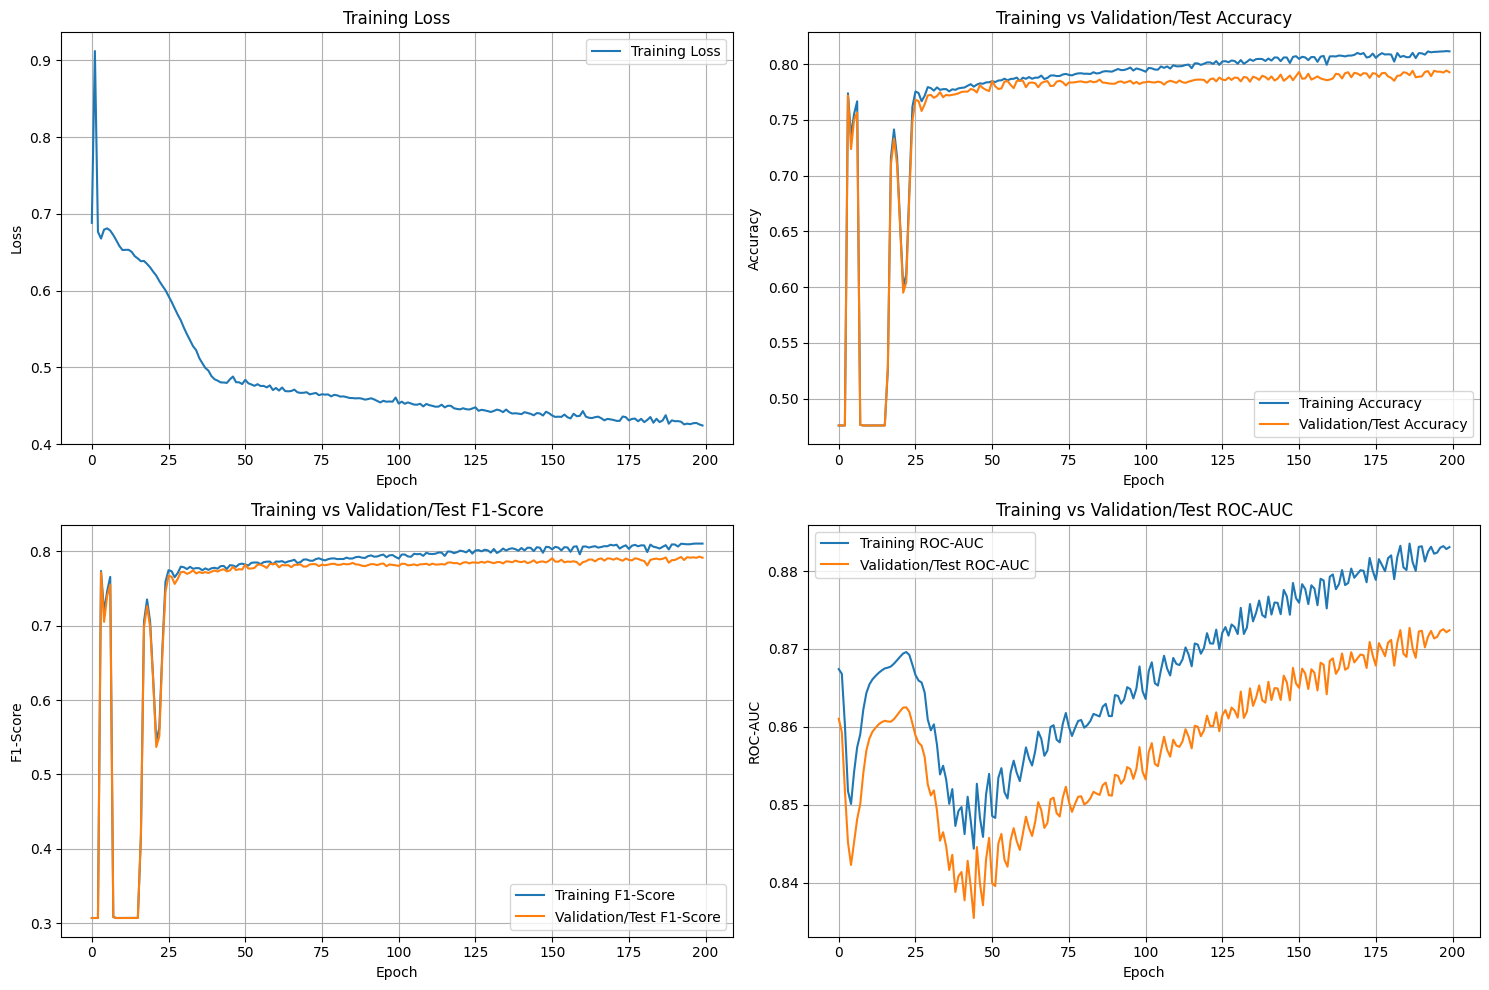


--- Ringkasan Nilai Akhir ---
Akhir - Train Acc: 0.8116, Val Acc: 0.7928, Gap: 0.0188
Akhir - Train F1:  0.8106,  Val F1:  0.7916,  Gap: 0.0190
Akhir - Train AUC: 0.8831, Val AUC: 0.8724, Gap: 0.0107

--- Analisis Berdasarkan Akurasi ---
  - Gap akurasi train-test (0.0188) kecil, tidak menunjukkan overfitting jelas.

--- Analisis Berdasarkan F1-Score ---
  - Gap F1-Score train-test (0.0190) kecil, tidak menunjukkan overfitting jelas.

--- Analisis Berdasarkan ROC-AUC ---
  - Gap ROC-AUC train-test (0.0107) kecil, tidak menunjukkan overfitting jelas.

--- Kesimpulan Gabungan ---
  -> Tidak ditemukan indikasi jelas underfitting maupun overfitting berdasarkan metrik akhir.


In [10]:
# @title ## 8. Evaluasi Performa dan Deteksi Overfitting/Underfitting (Lengkap)
# --- 8. Evaluasi Performa ---
acc, prec, rec, f1, auc = evaluate(data.test_mask) # Ambil juga AUC
print("\n--- Hasil Evaluasi Node2Vec + GCN ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}") # Tambahkan ROC-AUC

# --- Deteksi Overfitting & Underfitting ---
import matplotlib.pyplot as plt

print("\n--- Analisis Overfitting & Underfitting (Lengkap) ---")

# Plot loss, akurasi, F1, dan AUC pelatihan/validasi
plt.figure(figsize=(15, 10)) # Perbesar ukuran untuk 4 subplot

# Plot 1: Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation/Test Accuracy')
plt.title('Training vs Validation/Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: F1-Score
plt.subplot(2, 2, 3)
plt.plot(train_f1s, label='Training F1-Score')
plt.plot(val_f1s, label='Validation/Test F1-Score')
plt.title('Training vs Validation/Test F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

# Plot 4: ROC-AUC
plt.subplot(2, 2, 4)
plt.plot(train_aucs, label='Training ROC-AUC')
plt.plot(val_aucs, label='Validation/Test ROC-AUC')
plt.title('Training vs Validation/Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Ambil nilai akhir
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
final_train_f1 = train_f1s[-1]
final_val_f1 = val_f1s[-1]
final_train_auc = train_aucs[-1]
final_val_auc = val_aucs[-1]

# Threshold
THRESHOLD_ACC = 0.7 # Contoh nilai
THRESHOLD_F1 = 0.7
THRESHOLD_AUC = 0.7
THRESHOLD_GAP = 0.05

# --- Analisis ---
print("\n--- Ringkasan Nilai Akhir ---")
print(f"Akhir - Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}, Gap: {final_train_acc - final_val_acc:.4f}")
print(f"Akhir - Train F1:  {final_train_f1:.4f},  Val F1:  {final_val_f1:.4f},  Gap: {final_train_f1 - final_val_f1:.4f}")
print(f"Akhir - Train AUC: {final_train_auc:.4f}, Val AUC: {final_val_auc:.4f}, Gap: {final_train_auc - final_val_auc:.4f}")

# Analisis berdasarkan Akurasi
print("\n--- Analisis Berdasarkan Akurasi ---")
if final_train_acc < THRESHOLD_ACC:
    print(f"  - Akurasi pelatihan ({final_train_acc:.4f}) rendah, menunjukkan potensi UNDERFITTING.")
    is_underfit_acc = True
else:
    is_underfit_acc = False

gap_acc = final_train_acc - final_val_acc
if gap_acc > THRESHOLD_GAP:
    print(f"  - Gap akurasi train-test ({gap_acc:.4f}) besar, menunjukkan potensi OVERFITTING.")
    is_overfit_acc = True
elif not is_underfit_acc: # Jika tidak underfit, dan gap kecil, maka seimbang
    print(f"  - Gap akurasi train-test ({gap_acc:.4f}) kecil, tidak menunjukkan overfitting jelas.")
    is_overfit_acc = False
else:
    is_overfit_acc = False # Jika underfit, overfit tidak relevan

# Analisis berdasarkan F1-Score
print("\n--- Analisis Berdasarkan F1-Score ---")
if final_train_f1 < THRESHOLD_F1:
    print(f"  - F1-Score pelatihan ({final_train_f1:.4f}) rendah, menunjukkan potensi UNDERFITTING.")
    is_underfit_f1 = True
else:
    is_underfit_f1 = False

gap_f1 = final_train_f1 - final_val_f1
if gap_f1 > THRESHOLD_GAP:
    print(f"  - Gap F1-Score train-test ({gap_f1:.4f}) besar, menunjukkan potensi OVERFITTING.")
    is_overfit_f1 = True
elif not is_underfit_f1:
    print(f"  - Gap F1-Score train-test ({gap_f1:.4f}) kecil, tidak menunjukkan overfitting jelas.")
    is_overfit_f1 = False
else:
    is_overfit_f1 = False

# Analisis berdasarkan ROC-AUC
print("\n--- Analisis Berdasarkan ROC-AUC ---")
if final_train_auc < THRESHOLD_AUC:
    print(f"  - ROC-AUC pelatihan ({final_train_auc:.4f}) rendah, menunjukkan potensi UNDERFITTING.")
    is_underfit_auc = True
else:
    is_underfit_auc = False

gap_auc = final_train_auc - final_val_auc
if gap_auc > THRESHOLD_GAP:
    print(f"  - Gap ROC-AUC train-test ({gap_auc:.4f}) besar, menunjukkan potensi OVERFITTING.")
    is_overfit_auc = True
elif not is_underfit_auc:
    print(f"  - Gap ROC-AUC train-test ({gap_auc:.4f}) kecil, tidak menunjukkan overfitting jelas.")
    is_overfit_auc = False
else:
    is_overfit_auc = False

# --- Kesimpulan Gabungan ---
print("\n--- Kesimpulan Gabungan ---")
underfit_metrics = []
overfit_metrics = []

if is_underfit_acc:
    underfit_metrics.append("Akurasi")
if is_underfit_f1:
    underfit_metrics.append("F1-Score")
if is_underfit_auc:
    underfit_metrics.append("ROC-AUC")

if is_overfit_acc:
    overfit_metrics.append("Akurasi")
if is_overfit_f1:
    overfit_metrics.append("F1-Score")
if is_overfit_auc:
    overfit_metrics.append("ROC-AUC")

if underfit_metrics:
    print(f"  -> Potensi UNDERFITTING terdeteksi berdasarkan: {', '.join(underfit_metrics)}")
if overfit_metrics:
    print(f"  -> Potensi OVERFITTING terdeteksi berdasarkan: {', '.join(overfit_metrics)}")
if not underfit_metrics and not overfit_metrics:
    print(f"  -> Tidak ditemukan indikasi jelas underfitting maupun overfitting berdasarkan metrik akhir.")


In [11]:
# --- Analisis Overfitting dan Underfitting ---
print("\n--- Analisis Overfitting dan Underfitting (Lengkap: Akurasi, F1-Score, ROC-AUC) ---")

# Threshold untuk menentukan apakah kinerja dianggap 'rendah'
LOW_PERFORMANCE_THRESHOLD_ACC = 0.6  # Contoh nilai
LOW_PERFORMANCE_THRESHOLD_F1 = 0.6
LOW_PERFORMANCE_THRESHOLD_AUC = 0.6
# Threshold untuk menentukan apakah gap besar
LARGE_GAP_THRESHOLD = 0.05

# Ambil data dari history untuk satu model
model_name = 'current_model'  # Ganti jika nama model berbeda
epochs = history[model_name]['epochs']
train_accs = history[model_name]['train_acc']
test_accs = history[model_name]['test_acc']
train_f1s = history[model_name]['train_f1']
test_f1s = history[model_name]['test_f1']
train_aucs = history[model_name]['train_auc']
test_aucs = history[model_name]['test_auc']
train_losses = history[model_name]['train_loss']

if not epochs:
    print(f"Peringatan: Tidak ada data evaluasi dicatat untuk {model_name}.")
    # Plot loss tetap bisa dilakukan
    if train_losses:
        plt.figure(figsize=(6, 4))
        plt.plot(list(range(len(train_losses))), train_losses, label=f'Training Loss - {model_name}')
        plt.title(f'Training Loss Over Epochs - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    # Plot metrik (dengan marker hanya di titik evaluasi — sesuai gambar referensi)
    plt.figure(figsize=(18, 4))

    # Plot 1: Training Loss
    plt.subplot(1, 4, 1)
    all_epochs_for_loss = list(range(len(train_losses)))
    plt.plot(all_epochs_for_loss, train_losses, label='Training Loss', alpha=0.7)
    plt.title(f'Training Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy — marker hanya di titik evaluasi (misal: tiap 25 epoch)
    plt.subplot(1, 4, 2)
    # Plot garis tanpa marker dulu
    plt.plot(epochs, train_accs, color='steelblue', linestyle='-', linewidth=1.5, label='Training Accuracy')
    plt.plot(epochs, test_accs, color='orange', linestyle='-', linewidth=1.5, label='Test Accuracy')
    # Tambahkan marker hanya di titik evaluasi (misal: tiap 25 epoch)
    eval_epochs = [e for e in epochs if e % 25 == 0]  # Asumsi evaluasi tiap 25 epoch
    for e in eval_epochs:
        idx = epochs.index(e)
        plt.plot(e, train_accs[idx], marker='o', color='steelblue', markersize=6, markeredgecolor='black', markerfacecolor='white')
        plt.plot(e, test_accs[idx], marker='s', color='orange', markersize=6, markeredgecolor='black', markerfacecolor='white')
    plt.title(f'Training vs Test Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1-Score — marker hanya di titik evaluasi
    plt.subplot(1, 4, 3)
    plt.plot(epochs, train_f1s, color='steelblue', linestyle='-', linewidth=1.5, label='Training F1-Score')
    plt.plot(epochs, test_f1s, color='orange', linestyle='-', linewidth=1.5, label='Test F1-Score')
    for e in eval_epochs:
        idx = epochs.index(e)
        plt.plot(e, train_f1s[idx], marker='o', color='steelblue', markersize=6, markeredgecolor='black', markerfacecolor='white')
        plt.plot(e, test_f1s[idx], marker='s', color='orange', markersize=6, markeredgecolor='black', markerfacecolor='white')
    plt.title(f'Training vs Test F1-Score - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: ROC-AUC — marker hanya di titik evaluasi
    plt.subplot(1, 4, 4)
    plt.plot(epochs, train_aucs, color='steelblue', linestyle='-', linewidth=1.5, label='Training ROC-AUC')
    plt.plot(epochs, test_aucs, color='orange', linestyle='-', linewidth=1.5, label='Test ROC-AUC')
    for e in eval_epochs:
        idx = epochs.index(e)
        plt.plot(e, train_aucs[idx], marker='o', color='steelblue', markersize=6, markeredgecolor='black', markerfacecolor='white')
        plt.plot(e, test_aucs[idx], marker='s', color='orange', markersize=6, markeredgecolor='black', markerfacecolor='white')
    plt.title(f'Training vs Test ROC-AUC - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Analisis Underfitting ---
    # Ambil nilai akhir dari data evaluasi berkala
    final_train_acc = train_accs[-1] if train_accs else -1
    final_test_acc = test_accs[-1] if test_accs else -1
    final_train_f1 = train_f1s[-1] if train_f1s else -1
    final_test_f1 = test_f1s[-1] if test_f1s else -1
    final_train_auc = train_aucs[-1] if train_aucs else -1
    final_test_auc = test_aucs[-1] if test_aucs else -1

    print(f"\n--- Analisis Underfitting dan Overfitting untuk {model_name} ---")

    # Analisis berdasarkan akurasi
    if final_train_acc != -1 and final_test_acc != -1:
        gap_acc = final_train_acc - final_test_acc
        is_underfit_acc = final_train_acc < LOW_PERFORMANCE_THRESHOLD_ACC
        is_overfit_acc = gap_acc > LARGE_GAP_THRESHOLD

        print(f"Akurasi: Train={final_train_acc:.4f}, Test={final_test_acc:.4f}, Gap={gap_acc:.4f}")
        if is_underfit_acc:
            print("  - Akurasi pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_acc:
            print("  - Gap akurasi train-test besar, menunjukkan potensi overfitting.")
        else:
            print("  - Akurasi pelatihan dan test baik & gap kecil, model tampaknya seimbang.")

    # Analisis berdasarkan F1-Score
    if final_train_f1 != -1 and final_test_f1 != -1:
        gap_f1 = final_train_f1 - final_test_f1
        is_underfit_f1 = final_train_f1 < LOW_PERFORMANCE_THRESHOLD_F1
        is_overfit_f1 = gap_f1 > LARGE_GAP_THRESHOLD

        print(f"F1-Score: Train={final_train_f1:.4f}, Test={final_test_f1:.4f}, Gap={gap_f1:.4f}")
        if is_underfit_f1:
            print("  - F1-Score pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_f1:
            print("  - Gap F1-Score train-test besar, menunjukkan potensi overfitting.")
        else:
            print("  - F1-Score pelatihan dan test baik & gap kecil, model tampaknya seimbang.")

    # Analisis berdasarkan ROC-AUC
    if final_train_auc != -1 and final_test_auc != -1:
        gap_auc = final_train_auc - final_test_auc
        is_underfit_auc = final_train_auc < LOW_PERFORMANCE_THRESHOLD_AUC
        is_overfit_auc = gap_auc > LARGE_GAP_THRESHOLD

        print(f"ROC-AUC: Train={final_train_auc:.4f}, Test={final_test_auc:.4f}, Gap={gap_auc:.4f}")
        if is_underfit_auc:
            print("  - ROC-AUC pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_auc:
            print("  - Gap ROC-AUC train-test besar, menunjukkan potensi overfitting.")
        else:
            print("  - ROC-AUC pelatihan dan test baik & gap kecil, model tampaknya seimbang.")

    # Kesimpulan Gabungan Sederhana (contoh)
    underfit_indicators = [final_train_acc < LOW_PERFORMANCE_THRESHOLD_ACC if final_train_acc != -1 else False,
                           final_train_f1 < LOW_PERFORMANCE_THRESHOLD_F1 if final_train_f1 != -1 else False,
                           final_train_auc < LOW_PERFORMANCE_THRESHOLD_AUC if final_train_auc != -1 else False]
    overfit_indicators = [(final_train_acc - final_test_acc) > LARGE_GAP_THRESHOLD if final_train_acc != -1 and final_test_acc != -1 else False,
                          (final_train_f1 - final_test_f1) > LARGE_GAP_THRESHOLD if final_train_f1 != -1 and final_test_f1 != -1 else False,
                          (final_train_auc - final_test_auc) > LARGE_GAP_THRESHOLD if final_train_auc != -1 and final_test_auc != -1 else False]

    if any(underfit_indicators):
        print(f"\n  -> Kesimpulan: Model {model_name} MUNGKIN mengalami UNDERFITTING (kinerja pelatihan rendah).")
    elif any(overfit_indicators):
        print(f"\n  -> Kesimpulan: Model {model_name} MUNGKIN mengalami OVERFITTING (gap train-test besar).")
    else:
        print(f"\n  -> Kesimpulan: Model {model_name} TAMPAKNYA seimbang (kinerja baik dan gap kecil).")


--- Analisis Overfitting dan Underfitting (Lengkap: Akurasi, F1-Score, ROC-AUC) ---


NameError: name 'history' is not defined

Jumlah node: 19013
Jumlah node train: 13309 (70.0%)
Jumlah node val: 2851 (15.0%)
Jumlah node test: 2853 (15.0%)
Epoch   0, Loss: 0.4324, Train Acc: 0.8040, Val Acc: 0.8148, Test Acc: 0.8191
Epoch  20, Loss: 0.4275, Train Acc: 0.8059, Val Acc: 0.8120, Test Acc: 0.8209
Epoch  40, Loss: 0.4291, Train Acc: 0.8068, Val Acc: 0.8155, Test Acc: 0.8188
Epoch  60, Loss: 0.4190, Train Acc: 0.8067, Val Acc: 0.8053, Test Acc: 0.8156
Epoch  80, Loss: 0.4184, Train Acc: 0.8069, Val Acc: 0.8127, Test Acc: 0.8160
Epoch 100, Loss: 0.4263, Train Acc: 0.8095, Val Acc: 0.8148, Test Acc: 0.8188
Epoch 120, Loss: 0.4226, Train Acc: 0.8103, Val Acc: 0.8166, Test Acc: 0.8195
Epoch 140, Loss: 0.4127, Train Acc: 0.8116, Val Acc: 0.8166, Test Acc: 0.8198
Epoch 160, Loss: 0.4124, Train Acc: 0.8138, Val Acc: 0.8166, Test Acc: 0.8195
Epoch 180, Loss: 0.4111, Train Acc: 0.8128, Val Acc: 0.8194, Test Acc: 0.8233
Training selesai.

--- Analisis Overfitting dan Underfitting (Lengkap: Akurasi, F1-Score, ROC-AUC) ---


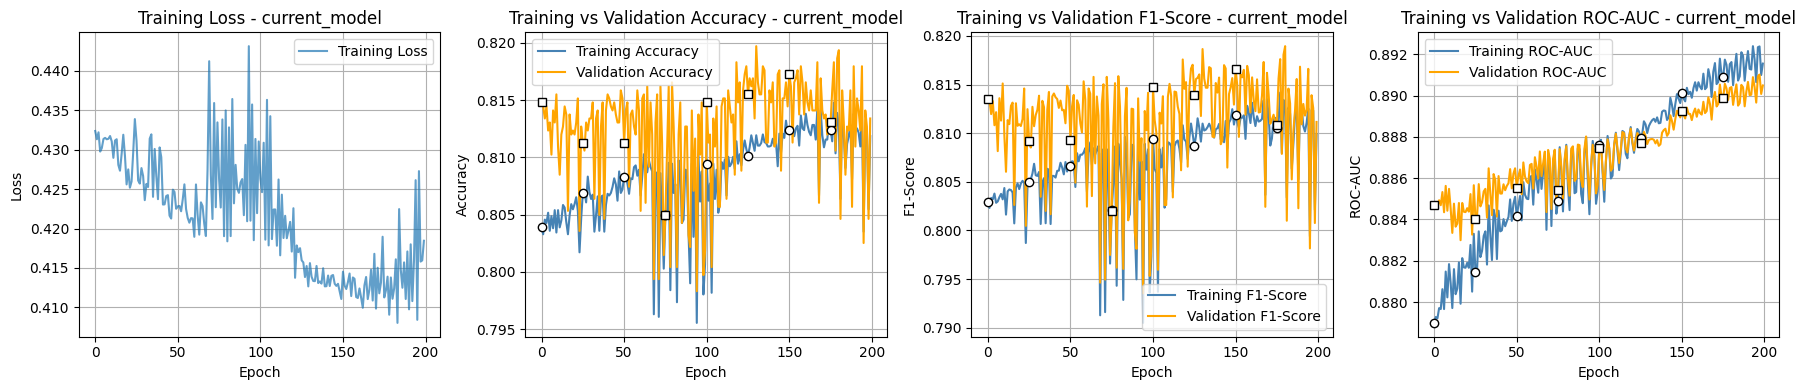


--- Analisis Underfitting dan Overfitting untuk current_model (Berdasarkan Train vs Val) ---
Akurasi: Train=0.8119, Val=0.8134, Gap=-0.0015
  - Akurasi pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.
F1-Score: Train=0.8099, Val=0.8112, Gap=-0.0012
  - F1-Score pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.
ROC-AUC: Train=0.8915, Val=0.8905, Gap=0.0011
  - ROC-AUC pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.

  -> Kesimpulan: Model current_model TAMPAKNYA seimbang (kinerja baik dan gap kecil).


NameError: name 'test_acs' is not defined

In [12]:
# @title ## 7. Pelatihan dan Evaluasi Model (Diperbarui - 70:15:15)
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# --- 7. Fungsi Pelatihan dan Evaluasi ---
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask, return_probs=False):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()
        # Ambil probabilitas untuk ROC-AUC
        y_probs_tensor = torch.exp(out[mask]) # softmax dari log_softmax
        y_probs = y_probs_tensor.cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        # Hitung ROC-AUC
        unique_labels = np.unique(y_true)
        if len(unique_labels) == 2: # Asumsi biner
            try:
                y_probs_positive_class = y_probs[:, 1] # Prob kelas positif (1)
                roc_auc = roc_auc_score(y_true, y_probs_positive_class)
            except ValueError:
                roc_auc = 0.0
        else:
            # Untuk multikelas, gunakan 'ovr' (one-vs-rest)
            try:
                roc_auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='weighted')
            except ValueError:
                roc_auc = 0.0 # Jika tidak bisa dihitung (misalnya hanya satu kelas dalam mask)

        if return_probs:
            return acc, prec, rec, f1, roc_auc, y_probs
        return acc, prec, rec, f1, roc_auc

# --- Pembagian Data (70:15:15) ---
# Asumsi data.y adalah label untuk semua node
num_nodes = data.y.size(0)
indices = torch.randperm(num_nodes)

# Hitung jumlah node untuk setiap split
train_size = int(0.70 * num_nodes)
val_size = int(0.15 * num_nodes)
test_size = num_nodes - train_size - val_size # Sisa untuk test (sekitar 15%)

# Buat masker
train_indices = indices[:train_size]
val_indices = indices[train_size : train_size + val_size]
test_indices = indices[train_size + val_size :]

# Inisialisasi masker
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Set nilai True untuk indeks yang sesuai
data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

print(f"Jumlah node: {num_nodes}")
print(f"Jumlah node train: {data.train_mask.sum().item()} ({data.train_mask.sum().item()/num_nodes*100:.1f}%)")
print(f"Jumlah node val: {data.val_mask.sum().item()} ({data.val_mask.sum().item()/num_nodes*100:.1f}%)")
print(f"Jumlah node test: {data.test_mask.sum().item()} ({data.test_mask.sum().item()/num_nodes*100:.1f}%)")

# --- Proses Pelatihan ---
epochs = 200
train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = [] # Tambahkan untuk akurasi test
train_f1s = []
val_f1s = []
test_f1s = [] # Tambahkan untuk F1 test
train_aucs = []
val_aucs = []
test_aucs = [] # Tambahkan untuk AUC test

for epoch in range(epochs):
    loss = train()
    train_losses.append(loss)

    # Evaluasi pada set pelatihan, validasi, dan pengujian
    train_acc, _, _, train_f1, train_auc = evaluate(data.train_mask)
    val_acc, _, _, val_f1, val_auc = evaluate(data.val_mask)
    test_acc, _, _, test_f1, test_auc = evaluate(data.test_mask) # Evaluasi test

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc) # Simpan akurasi test
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    test_f1s.append(test_f1) # Simpan F1 test
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    test_aucs.append(test_auc) # Simpan AUC test

    # Cetak hasil hanya setiap 20 epoch untuk mengurangi verbosity
    if epoch % 20 == 0:
        print(f'Epoch {epoch:3d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

print("Training selesai.")

# --- Simpan History (Opsional, untuk plot dan analisis) ---
# Karena tidak ada loop model yang berbeda, kita simpan ke dictionary sederhana
history = {}
model_name = 'current_model'
history[model_name] = {
    'epochs': list(range(epochs)),
    'train_acc': train_accuracies,
    'val_acc': val_accuracies, # Ganti dari test_acc
    'test_acc': test_accuracies, # Tambahkan test_acc
    'train_f1': train_f1s,
    'val_f1': val_f1s, # Ganti dari test_f1
    'test_f1': test_f1s, # Tambahkan test_f1
    'train_auc': train_aucs,
    'val_auc': val_aucs, # Ganti dari test_auc
    'test_auc': test_aucs, # Tambahkan test_auc
    'train_loss': train_losses,
}

# --- Analisis Overfitting dan Underfitting ---
print("\n--- Analisis Overfitting dan Underfitting (Lengkap: Akurasi, F1-Score, ROC-AUC) ---")

# Threshold untuk menentukan apakah kinerja dianggap 'rendah'
LOW_PERFORMANCE_THRESHOLD_ACC = 0.6
LOW_PERFORMANCE_THRESHOLD_F1 = 0.6
LOW_PERFORMANCE_THRESHOLD_AUC = 0.6
# Threshold untuk menentukan apakah gap besar
LARGE_GAP_THRESHOLD = 0.05

# Ambil data dari history
epochs = history[model_name]['epochs']
train_accs = history[model_name]['train_acc']
val_accs = history[model_name]['val_acc'] # Gunakan val_acc
train_f1s = history[model_name]['train_f1']
val_f1s = history[model_name]['val_f1'] # Gunakan val_f1
train_aucs = history[model_name]['train_auc']
val_aucs = history[model_name]['val_auc'] # Gunakan val_auc
train_losses = history[model_name]['train_loss']

if not epochs:
    print(f"Peringatan: Tidak ada data evaluasi dicatat untuk {model_name}.")
    # Plot loss tetap bisa dilakukan
    if train_losses:
        plt.figure(figsize=(6, 4))
        plt.plot(list(range(len(train_losses))), train_losses, label=f'Training Loss - {model_name}')
        plt.title(f'Training Loss Over Epochs - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    # Plot metrik (dengan marker hanya di titik evaluasi — sesuai gambar referensi)
    # Karena kita mengevaluasi setiap epoch, kita plot semua titik
    plt.figure(figsize=(18, 4))

    # Plot 1: Training Loss
    plt.subplot(1, 4, 1)
    all_epochs_for_loss = list(range(len(train_losses)))
    plt.plot(all_epochs_for_loss, train_losses, label='Training Loss', alpha=0.7)
    plt.title(f'Training Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy — Training vs Validation
    plt.subplot(1, 4, 2)
    plt.plot(epochs, train_accs, color='steelblue', linestyle='-', linewidth=1.5, label='Training Accuracy')
    plt.plot(epochs, val_accs, color='orange', linestyle='-', linewidth=1.5, label='Validation Accuracy') # Plot val
    # Tambahkan marker setiap 25 epoch (atau sesuaikan)
    eval_epochs = [e for e in epochs if e % 25 == 0]
    for e in eval_epochs:
        idx = epochs.index(e)
        plt.plot(e, train_accs[idx], marker='o', color='steelblue', markersize=6, markeredgecolor='black', markerfacecolor='white')
        plt.plot(e, val_accs[idx], marker='s', color='orange', markersize=6, markeredgecolor='black', markerfacecolor='white')
    plt.title(f'Training vs Validation Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1-Score — Training vs Validation
    plt.subplot(1, 4, 3)
    plt.plot(epochs, train_f1s, color='steelblue', linestyle='-', linewidth=1.5, label='Training F1-Score')
    plt.plot(epochs, val_f1s, color='orange', linestyle='-', linewidth=1.5, label='Validation F1-Score') # Plot val
    for e in eval_epochs:
        idx = epochs.index(e)
        plt.plot(e, train_f1s[idx], marker='o', color='steelblue', markersize=6, markeredgecolor='black', markerfacecolor='white')
        plt.plot(e, val_f1s[idx], marker='s', color='orange', markersize=6, markeredgecolor='black', markerfacecolor='white')
    plt.title(f'Training vs Validation F1-Score - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: ROC-AUC — Training vs Validation
    plt.subplot(1, 4, 4)
    plt.plot(epochs, train_aucs, color='steelblue', linestyle='-', linewidth=1.5, label='Training ROC-AUC')
    plt.plot(epochs, val_aucs, color='orange', linestyle='-', linewidth=1.5, label='Validation ROC-AUC') # Plot val
    for e in eval_epochs:
        idx = epochs.index(e)
        plt.plot(e, train_aucs[idx], marker='o', color='steelblue', markersize=6, markeredgecolor='black', markerfacecolor='white')
        plt.plot(e, val_aucs[idx], marker='s', color='orange', markersize=6, markeredgecolor='black', markerfacecolor='white')
    plt.title(f'Training vs Validation ROC-AUC - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Analisis Underfitting & Overfitting ---
    # Ambil nilai akhir dari data evaluasi
    final_train_acc = train_accs[-1] if train_accs else -1
    final_val_acc = val_accs[-1] if val_accs else -1 # Gunakan val_acc
    final_train_f1 = train_f1s[-1] if train_f1s else -1
    final_val_f1 = val_f1s[-1] if val_f1s else -1 # Gunakan val_f1
    final_train_auc = train_aucs[-1] if train_aucs else -1
    final_val_auc = val_aucs[-1] if val_aucs else -1 # Gunakan val_auc

    print(f"\n--- Analisis Underfitting dan Overfitting untuk {model_name} (Berdasarkan Train vs Val) ---")

    # Analisis berdasarkan akurasi
    if final_train_acc != -1 and final_val_acc != -1:
        gap_acc = final_train_acc - final_val_acc
        is_underfit_acc = final_train_acc < LOW_PERFORMANCE_THRESHOLD_ACC
        is_overfit_acc = gap_acc > LARGE_GAP_THRESHOLD

        print(f"Akurasi: Train={final_train_acc:.4f}, Val={final_val_acc:.4f}, Gap={gap_acc:.4f}")
        if is_underfit_acc:
            print("  - Akurasi pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_acc:
            print("  - Gap akurasi train-val besar, menunjukkan potensi overfitting.")
        else:
            print("  - Akurasi pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.")

    # Analisis berdasarkan F1-Score
    if final_train_f1 != -1 and final_val_f1 != -1:
        gap_f1 = final_train_f1 - final_val_f1
        is_underfit_f1 = final_train_f1 < LOW_PERFORMANCE_THRESHOLD_F1
        is_overfit_f1 = gap_f1 > LARGE_GAP_THRESHOLD

        print(f"F1-Score: Train={final_train_f1:.4f}, Val={final_val_f1:.4f}, Gap={gap_f1:.4f}")
        if is_underfit_f1:
            print("  - F1-Score pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_f1:
            print("  - Gap F1-Score train-val besar, menunjukkan potensi overfitting.")
        else:
            print("  - F1-Score pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.")

    # Analisis berdasarkan ROC-AUC
    if final_train_auc != -1 and final_val_auc != -1:
        gap_auc = final_train_auc - final_val_auc
        is_underfit_auc = final_train_auc < LOW_PERFORMANCE_THRESHOLD_AUC
        is_overfit_auc = gap_auc > LARGE_GAP_THRESHOLD

        print(f"ROC-AUC: Train={final_train_auc:.4f}, Val={final_val_auc:.4f}, Gap={gap_auc:.4f}")
        if is_underfit_auc:
            print("  - ROC-AUC pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_auc:
            print("  - Gap ROC-AUC train-val besar, menunjukkan potensi overfitting.")
        else:
            print("  - ROC-AUC pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.")

    # Kesimpulan Gabungan Sederhana
    underfit_indicators = [
        final_train_acc < LOW_PERFORMANCE_THRESHOLD_ACC if final_train_acc != -1 else False,
        final_train_f1 < LOW_PERFORMANCE_THRESHOLD_F1 if final_train_f1 != -1 else False,
        final_train_auc < LOW_PERFORMANCE_THRESHOLD_AUC if final_train_auc != -1 else False
    ]
    overfit_indicators = [
        (final_train_acc - final_val_acc) > LARGE_GAP_THRESHOLD if final_train_acc != -1 and final_val_acc != -1 else False,
        (final_train_f1 - final_val_f1) > LARGE_GAP_THRESHOLD if final_train_f1 != -1 and final_val_f1 != -1 else False,
        (final_train_auc - final_val_auc) > LARGE_GAP_THRESHOLD if final_train_auc != -1 and final_val_auc != -1 else False
    ]

    if any(underfit_indicators):
        print(f"\n  -> Kesimpulan: Model {model_name} MUNGKIN mengalami UNDERFITTING (kinerja pelatihan rendah).")
    elif any(overfit_indicators):
        print(f"\n  -> Kesimpulan: Model {model_name} MUNGKIN mengalami OVERFITTING (gap train-val besar).")
    else:
        print(f"\n  -> Kesimpulan: Model {model_name} TAMPAKNYA seimbang (kinerja baik dan gap kecil).")

    # Menampilkan akurasi final pada test set
    final_test_acc = test_acs[-1] if test_acs else -1
    final_test_f1 = test_f1s[-1] if test_f1s else -1
    final_test_auc = test_aucs[-1] if test_aucs else -1
    print(f"\nAkhir Pelatihan - Test Accuracy: {final_test_acc:.4f}, Test F1-Score: {final_test_f1:.4f}, Test ROC-AUC: {final_test_auc:.4f}")
